## Описание проекта

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

## Описание данных

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` — данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
root = 'datasets/final_steel/'
data_arc = pd.read_csv(root + 'data_arc.csv', parse_dates = ['Начало нагрева дугой', 'Конец нагрева дугой'])
data_bulk = pd.read_csv(root + 'data_bulk.csv')
data_bulk_time = pd.read_csv(root + 'data_bulk_time.csv')
data_gas = pd.read_csv(root + 'data_gas.csv')
data_temp = pd.read_csv(root + 'data_temp.csv', parse_dates = ['Время замера'])
data_wire = pd.read_csv(root + 'data_wire.csv')
data_wire_time = pd.read_csv(root + 'data_wire_time.csv')

In [3]:
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [4]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [5]:
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [6]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [7]:
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [8]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [9]:
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [10]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [11]:
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [12]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


In [13]:
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [15]:
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


## EDA

### Данные об электродах

In [17]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


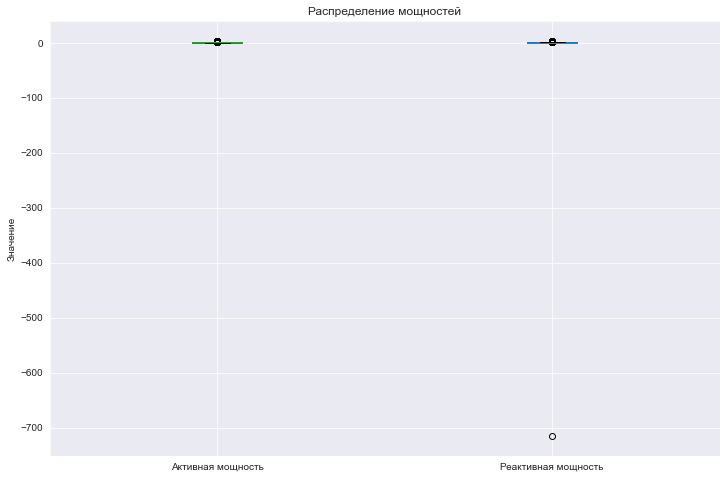

In [18]:
data_arc.boxplot(['Активная мощность', 'Реактивная мощность'])
plt.title('Распределение мощностей')
plt.ylabel('Значение')
plt.show()

In [19]:
# удалим выброс
data_arc = data_arc[data_arc['Реактивная мощность'] > -50].reset_index(drop=True)


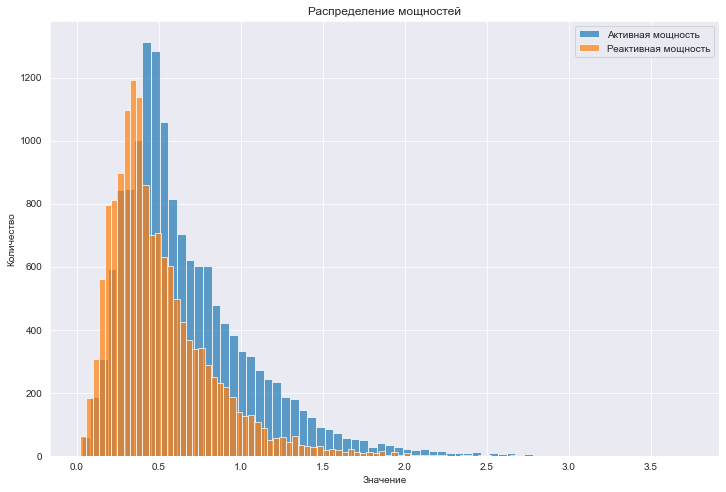

In [20]:
data_arc['Активная мощность'].plot(kind='hist', bins=70, legend=True, alpha=0.7)
data_arc['Реактивная мощность'].plot(kind='hist', bins=70, legend=True, alpha=0.7)
plt.title('Распределение мощностей')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

Сразу восстановим значение полной мощности, которое является куда более показательным нежели активная и реактивная по отдельности. Таким образом мы заодно избавимся от мультиколлинеарности в дальнейшем.

**Формула полной мощности**

$$S = \sqrt{P^2 + Q^2}$$ ,где P - активная мощность, Q - реактивная мощность

In [21]:
data_arc['Полная мощность'] = np.sqrt(data_arc['Активная мощность']**2 + data_arc['Реактивная мощность']**2)


Теперь нам не нужны значения активной и реактивной мощностей.

In [22]:
data_arc.drop(columns=['Активная мощность', 'Реактивная мощность'], inplace=True)

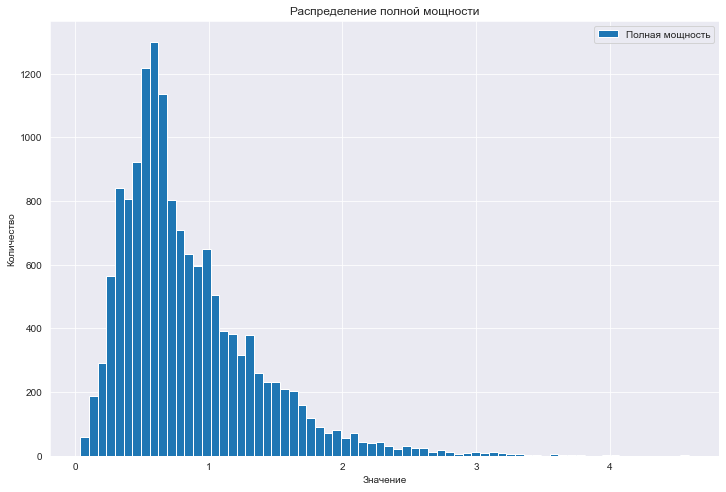

In [23]:
data_arc['Полная мощность'].plot(kind='hist', bins=70, legend=True)
plt.title('Распределение полной мощности')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

**Средняя полная мощность**

In [24]:
full_power = data_arc.groupby('key')['Полная мощность'].mean().reset_index()
full_power.columns = ['key', 'Средняя полная мощность']
full_power

,key,Средняя полная мощность
0,1,1.165279
1,2,0.912304
2,3,0.597907
3,4,0.953741
4,5,1.008939
...,...,...
3209,3237,0.968996
3210,3238,0.898847
3211,3239,0.701485
3212,3240,0.778371


**Суммарное время нагрева электродами, то есть сумму значений по всем промежуткам между запусками нагрева электродов.**

In [25]:
data_arc['Время нагрева'] = data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']

In [26]:
time_per_key = data_arc.groupby('key')['Время нагрева'].sum().reset_index()
time_per_key.columns = ['key','Суммарное время нагрева электродами']
time_per_key

,key,Суммарное время нагрева электродами
0,1,0 days 00:18:18
1,2,0 days 00:13:31
2,3,0 days 00:10:55
3,4,0 days 00:12:21
4,5,0 days 00:14:29
...,...,...
3209,3237,0 days 00:15:09
3210,3238,0 days 00:09:06
3211,3239,0 days 00:20:16
3212,3240,0 days 00:13:59


**Количество запусков нагрева электродами.** 

In [27]:
arc_count = data_arc.groupby('key')['Время нагрева'].count().reset_index()
arc_count.columns = ['key','Количество запусков нагрева']
arc_count

,key,Количество запусков нагрева
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4
...,...,...
3209,3237,5
3210,3238,3
3211,3239,8
3212,3240,5


### Данные о подаче сыпучих материалов

Поскольку перед нами не стоит задача о поиске какой-либо зависимости от состава материала, а некоторые сыпучие материалы добавляются крайней редко(<300), то мы объеденим таковые в `Bulk_other`.

In [28]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [29]:
bulks_for_sum = ['Bulk 1', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 13']
data_bulk['Bulk_other'] = data_bulk[bulks_for_sum].sum(axis=1)
data_bulk.drop(bulks_for_sum, axis=1, inplace=True)

Пропуски в объеме совпадают с пропусками по времени, логично предположить, что добавления сыпучих материалов не происходило в случае отсутствия значения. Заменим все пропуски на 0.

In [30]:
data_bulk.fillna(0,inplace=True)

### Результаты измерения температуры

In [31]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           15907 non-null  int64         
 1   Время замера  15907 non-null  datetime64[ns]
 2   Температура   13006 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 372.9 KB


Узнаем первую и последнюю температуры при замерах.

In [32]:
data_temp_pivot = data_temp.pivot_table(index='key', aggfunc=['max','min']).reset_index()
data_temp_pivot.columns = ['key','Время замера','Итоговая температура','Время первого замера','Начальная температура']
# Удаляем столбец 'Итоговая температура', т.к. данные по последнему
# замеру не соответствуют своему времени если есть пропуски
data_temp_pivot.drop(columns=['Итоговая температура'], inplace=True)
data_temp_pivot = data_temp_pivot.merge(data_temp, on=['key', 'Время замера'], how='left')
data_temp_pivot.head()

,key,Время замера,Время первого замера,Начальная температура,Температура
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0


In [33]:
data_temp_pivot.columns = ['key', 'Время последнего замера',
       'Время первого замера', 'Начальная температура',
       'Итоговая температура']

In [34]:
data_temp_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   key                      3216 non-null   int64         
 1   Время последнего замера  3216 non-null   datetime64[ns]
 2   Время первого замера     3216 non-null   datetime64[ns]
 3   Начальная температура    3216 non-null   float64       
 4   Итоговая температура     2477 non-null   float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 150.8 KB


Поскольку температура является для нас целевым признаком, то мы никак не можем заполнить пропуски. Просто удаляем те записи в которые температура не замерялась.

In [35]:
data_temp_pivot.dropna(subset=['Итоговая температура'], inplace=True)

**Длительность времени между первым и последним замером температуры**

In [36]:
data_temp_pivot['Время между замерами'] = data_temp_pivot['Время последнего замера'] - data_temp_pivot['Время первого замера']

### Данные о проволочных материалах

По аналогии с данными о подаче сыпучих материалов оставим лишь наиболее часто используемые столбцы, а остальные сгруппируем.

In [37]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [38]:
wires_for_sum = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
data_wire['Wire_other'] = data_wire[wires_for_sum].sum(axis=1)
data_wire.drop(wires_for_sum, axis=1, inplace=True)

In [39]:
data_wire.fillna(0,inplace=True)

### Общая таблица данных

Соединим все полученные данные.

In [40]:
data_final = time_per_key.merge(arc_count, on='key')
data_final = data_final.merge(full_power, on ='key')

In [41]:
data_final.describe()

,key,Суммарное время нагрева электродами,Количество запусков нагрева,Средняя полная мощность
count,3214.000000,3214,3214.000000,3214.000000
mean,1623.061294,0 days 00:13:14.545115121,4.628189,0.839603
std,934.739859,0 days 00:05:32.491076408,1.608866,0.254801
min,1.000000,0 days 00:00:57,1.000000,0.228541
25%,817.250000,0 days 00:09:31,4.000000,0.651715
50%,1623.500000,0 days 00:12:50,4.000000,0.816478
75%,2431.750000,0 days 00:16:23,6.000000,0.996717
max,3241.000000,0 days 01:09:49,16.000000,2.147979


In [42]:
data_final = data_temp_pivot.merge(data_final, on='key', how='left')

In [43]:
data_final = data_final.merge(data_bulk, on ='key', how='left')

In [44]:
data_final = data_final.merge(data_wire, on='key', how='left')

In [45]:
data_final = data_final.merge(data_gas, on='key', how='left')

Посмотрим на полученную финальную таблицу.

In [46]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2476
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype          
---  ------                               --------------  -----          
 0   key                                  2477 non-null   int64          
 1   Время последнего замера              2477 non-null   datetime64[ns] 
 2   Время первого замера                 2477 non-null   datetime64[ns] 
 3   Начальная температура                2477 non-null   float64        
 4   Итоговая температура                 2477 non-null   float64        
 5   Время между замерами                 2477 non-null   timedelta64[ns]
 6   Суммарное время нагрева электродами  2475 non-null   timedelta64[ns]
 7   Количество запусков нагрева          2475 non-null   float64        
 8   Средняя полная мощность              2475 non-null   float64        
 9   Bulk 3                               2408 non-null   float64        
 10  

Удалим записи содержащие NaN значения.

In [47]:
data_final.dropna(inplace=True)

In [48]:
data_final.head()

,key,Время последнего замера,Время первого замера,Начальная температура,Итоговая температура,Время между замерами,Суммарное время нагрева электродами,Количество запусков нагрева,Средняя полная мощность,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Bulk_other,Wire 1,Wire 2,Wire_other,Газ 1
0,1,2019-05-03 11:30:39,2019-05-03 11:16:18,1571.0,1613.0,0 days 00:14:21,0 days 00:18:18,5.0,1.165279,0.0,43.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986
1,2,2019-05-03 11:59:12,2019-05-03 11:37:27,1577.0,1602.0,0 days 00:21:45,0 days 00:13:31,4.0,0.912304,0.0,73.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561
2,3,2019-05-03 12:34:57,2019-05-03 12:13:17,1596.0,1599.0,0 days 00:21:40,0 days 00:10:55,5.0,0.597907,0.0,34.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793
3,4,2019-05-03 12:59:25,2019-05-03 12:52:57,1601.0,1625.0,0 days 00:06:28,0 days 00:12:21,4.0,0.953741,0.0,81.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219
4,5,2019-05-03 13:36:01,2019-05-03 13:23:19,1576.0,1602.0,0 days 00:12:42,0 days 00:14:29,4.0,1.008939,0.0,78.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692


Нам также необходимо перевести `время между замерами` и `суммарное время нагрева электродами` в секунды для удобства работы с ним и удалить признаки `Время последнего замера` и `Время первого замера`.

In [49]:
data_final['Суммарное время нагрева в секундах'] = data_final['Суммарное время нагрева электродами'].dt.total_seconds()
data_final['Время между замерами в секундах'] = data_final['Время между замерами'].dt.total_seconds()

In [50]:
data_final.drop(['Время последнего замера', 'Время первого замера', 'Время между замерами', 'Суммарное время нагрева электродами'], axis=1, inplace=True)

**Итоговая таблица**

In [51]:
data_final.head()


,key,Начальная температура,Итоговая температура,Количество запусков нагрева,Средняя полная мощность,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Bulk_other,Wire 1,Wire 2,Wire_other,Газ 1,Суммарное время нагрева в секундах,Время между замерами в секундах
0,1,1571.0,1613.0,5.0,1.165279,0.0,43.0,0.0,206.0,150.0,154.0,0.0,60.059998,0.00000,0.0,29.749986,1098.0,861.0
1,2,1577.0,1602.0,4.0,0.912304,0.0,73.0,0.0,206.0,149.0,154.0,0.0,96.052315,0.00000,0.0,12.555561,811.0,1305.0
2,3,1596.0,1599.0,5.0,0.597907,0.0,34.0,0.0,205.0,152.0,153.0,0.0,91.160157,0.00000,0.0,28.554793,655.0,1300.0
3,4,1601.0,1625.0,4.0,0.953741,0.0,81.0,0.0,207.0,153.0,154.0,0.0,89.063515,0.00000,0.0,18.841219,741.0,388.0
4,5,1576.0,1602.0,4.0,1.008939,0.0,78.0,0.0,203.0,151.0,152.0,0.0,89.238236,9.11456,0.0,5.413692,869.0,762.0


**Корреляция признаков**

In [52]:
data_final.corr().style.background_gradient(cmap='RdPu')


,key,Начальная температура,Итоговая температура,Количество запусков нагрева,Средняя полная мощность,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,Bulk_other,Wire 1,Wire 2,Wire_other,Газ 1,Суммарное время нагрева в секундах,Время между замерами в секундах
key,1.000000,-0.049919,-0.097242,-0.033585,0.022759,-0.007271,-0.026147,0.006241,0.025958,-0.110275,-0.045531,0.042750,-0.013564,0.043149,-0.020594,-0.043486,-0.029519,-0.002600
Начальная температура,-0.049919,1.000000,0.353292,-0.166090,-0.303082,-0.089475,0.122691,-0.101825,-0.035290,-0.077168,0.016995,-0.042919,0.155272,-0.106521,-0.062367,-0.048104,-0.285718,-0.025283
Итоговая температура,-0.097242,0.353292,1.000000,0.181146,0.191027,-0.035977,0.187970,-0.181816,0.267424,0.114617,0.266414,-0.116145,0.317575,-0.206672,-0.091003,0.059160,0.278716,0.097480
Количество запусков нагрева,-0.033585,-0.166090,0.181146,1.000000,0.035012,0.109238,-0.004237,0.152034,0.307230,0.333906,0.175047,0.187323,0.138280,0.078237,0.081376,0.403947,0.799038,0.587091
Средняя полная мощность,0.022759,-0.303082,0.191027,0.035012,1.000000,0.035880,-0.043016,0.042726,0.392658,0.340856,0.330532,-0.026985,-0.113784,-0.010163,0.003971,0.090084,0.568778,0.074563
Bulk 3,-0.007271,-0.089475,-0.035977,0.109238,0.035880,1.000000,-0.295431,0.065284,0.018371,0.010772,-0.012860,-0.061826,0.039637,0.095723,0.001943,0.059628,0.092682,0.025857
Bulk 4,-0.026147,0.122691,0.187970,-0.004237,-0.043016,-0.295431,1.000000,-0.251562,0.105791,-0.090602,0.101514,-0.016073,0.297591,-0.268142,-0.036253,0.017578,-0.028237,0.000188
Bulk 6,0.006241,-0.101825,-0.181816,0.152034,0.042726,0.065284,-0.251562,1.000000,-0.112902,0.177490,-0.109316,0.013621,-0.235793,0.204627,-0.053967,0.139625,0.161597,0.149048
Bulk 12,0.025958,-0.035290,0.267424,0.307230,0.392658,0.018371,0.105791,-0.112902,1.000000,0.481541,0.614479,0.000652,0.170167,-0.098263,-0.138347,0.217332,0.466789,0.220503
Bulk 14,-0.110275,-0.077168,0.114617,0.333906,0.340856,0.010772,-0.090602,0.177490,0.481541,1.000000,0.265354,-0.057938,-0.053835,0.036309,-0.031605,0.268889,0.461181,0.185683


## План решения задачи

Мы получили итоговую таблицу данных. Для дальнейшней работы сформирован план:
- Разделить данные на тренировочную и тестовую выборки
    - Проверить размерность
- Обучить модель RandomForestRegressor
- Обучить модель LinearRegression
- Обучить модель CatBoostRegressor
- Сравнить полученные метрики и выбрать лучшую модель
- Вывести важность факторов выбранной модели
- Написать общий вывод по всем пунктам

## Моделирование

### Тестовая и тренировочная выборки

In [53]:
x = data_final.drop(columns=['Итоговая температура'])
y = data_final['Итоговая температура']

In [54]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25, random_state=42, shuffle=True)

In [55]:
# Проверим размерность наших выборок
print(f'train {x_train.shape, y_train.shape}')
print(f'test {x_test.shape, y_test.shape}')

train ((1746, 17), (1746,))
test ((583, 17), (583,))


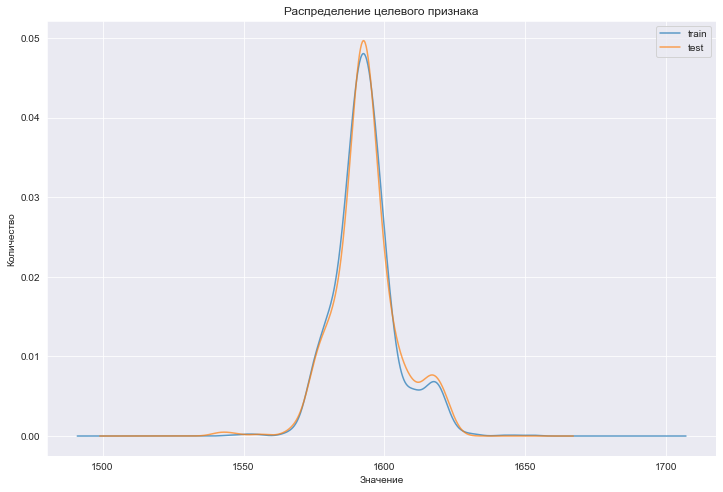

In [56]:
# Посмотрим на распределение
y_train.plot(kind='density', legend=True, alpha=0.7, label='train')
y_test.plot(kind='density', legend=True, alpha=0.7, label='test')
plt.title('Распределение целевого признака')
plt.xlabel('Значение')
plt.ylabel('Количество')
plt.show()

### Первая модель RandomForestRegressor

In [57]:
params = {'bootstrap': [True],
               'criterion': ['mse', 'mae'],
               'max_depth': [5, 7, 9, 12, 20, 30, 42],
               'max_features': ['auto', 1/3],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [5, 10, 15],
               'n_estimators': [100, 150, 200]}
rfr = RandomForestRegressor(random_state=42, n_jobs=-1, verbose=2)
grid_rfr = RandomizedSearchCV(rfr, params, cv=5, scoring='neg_mean_absolute_error')
grid_rfr.fit(x_train, y_train)
result_rfr = -1*grid_rfr.best_score_
predict_rfr = grid_rfr.predict(x_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    3.1s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.4s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]:

building tree 1 of 150
building tree 2 of 150building tree 3 of 150

building tree 4 of 150building tree 5 of 150

building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150building tree 18 of 150

building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150building tree 28 of 150

building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150building tree 33 of 150

building tree 34 of 150building tree 35 of 150

building tree 36 of 150
building tree 37 of 150building tree 38 of 150

building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
b

[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    0.0s


building tree 102 of 150building tree 103 of 150

building tree 104 of 150
building tree 105 of 150building tree 106 of 150

building tree 107 of 150
building tree 108 of 150
building tree 109 of 150
building tree 110 of 150
building tree 111 of 150
building tree 112 of 150
building tree 113 of 150
building tree 114 of 150building tree 115 of 150

building tree 116 of 150
building tree 117 of 150
building tree 118 of 150building tree 119 of 150

building tree 120 of 150
building tree 121 of 150
building tree 122 of 150
building tree 123 of 150building tree 124 of 150

building tree 125 of 150
building tree 126 of 150
building tree 127 of 150
building tree 128 of 150
building tree 129 of 150
building tree 130 of 150
building tree 131 of 150
building tree 132 of 150
building tree 133 of 150
building tree 134 of 150
building tree 135 of 150
building tree 136 of 150
building tree 137 of 150
building tree 138 of 150
building tree 139 of 150
building tree 140 of 150
building tree 141 of 150


[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    0.2s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:    0.0s finished


In [58]:
mae_rfr = mean_absolute_error(y_test, predict_rfr)
best_params_rfr = grid_rfr.best_params_

In [59]:
# Наилучшие параметры
best_params_rfr

{'n_estimators': 150,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 12,
 'criterion': 'mse',
 'bootstrap': True}

MAE полученная при использовании модели RandomForestRegressor.

In [60]:
print(f'MAE полученное на тренировочной выборке: {result_rfr}')
print(f'MAE полученное на тестовой выборке: {mae_rfr}')

MAE полученное на тренировочной выборке: 4.570262782585499
MAE полученное на тестовой выборке: 4.526255469879407


### Вторая модель LinearRegression

In [61]:
params = {'normalize': [True, False]}
lr = LinearRegression(n_jobs=-1)
grid_lr = GridSearchCV(lr, params, cv=5, scoring='neg_mean_absolute_error')
grid_lr.fit(x_train, y_train)
result_lr = -1*grid_lr.best_score_
predict_lr = grid_lr.predict(x_test)

In [62]:
mae_lr = mean_absolute_error(y_test, predict_lr)
best_params_lr = grid_lr.best_params_


In [63]:
# Наилучшие параметры
best_params_lr


{'normalize': True}

MAE полученная при использовании модели LinearRegression.


In [64]:
print(f'MAE полученное на тренировочной выборке: {result_lr}')
print(f'MAE полученное на тестовой выборке: {mae_lr}')


MAE полученное на тренировочной выборке: 5.699620008075283
MAE полученное на тестовой выборке: 6.096504543012133


### Третья модель CatBoostRegressor

In [65]:
model = CatBoostRegressor(iterations=5000, depth=3, loss_function='MAE', verbose=100)
model.fit(x_train,y_train, eval_set=(x_test,y_test))

0:	learn: 7.9721468	test: 8.0360367	best: 8.0360367 (0)	total: 141ms	remaining: 11m 42s
100:	learn: 5.2967270	test: 5.6165278	best: 5.6165278 (100)	total: 222ms	remaining: 10.8s
200:	learn: 4.7110941	test: 5.1334856	best: 5.1334856 (200)	total: 290ms	remaining: 6.92s
300:	learn: 4.3608067	test: 4.8693319	best: 4.8693319 (300)	total: 358ms	remaining: 5.59s
400:	learn: 4.1070111	test: 4.7165364	best: 4.7165364 (400)	total: 436ms	remaining: 5s
500:	learn: 3.9363604	test: 4.6304021	best: 4.6304021 (500)	total: 514ms	remaining: 4.61s
600:	learn: 3.8017671	test: 4.5538278	best: 4.5533400 (599)	total: 587ms	remaining: 4.29s
700:	learn: 3.6960382	test: 4.4983359	best: 4.4983359 (700)	total: 664ms	remaining: 4.07s
800:	learn: 3.6247134	test: 4.4715084	best: 4.4707546 (795)	total: 737ms	remaining: 3.87s
900:	learn: 3.5489855	test: 4.4430248	best: 4.4430248 (900)	total: 812ms	remaining: 3.69s
1000:	learn: 3.4838097	test: 4.4115546	best: 4.4106651 (999)	total: 889ms	remaining: 3.55s
1100:	learn: 3

In [66]:
cat_predict = model.predict(x_test)
mae_cat = mean_absolute_error(y_test, cat_predict)

In [67]:
print(f'MAE полученное на тестовой выборке: {mae_cat}')

MAE полученное на тестовой выборке: 4.245783239894193


## Выбор лучшей модели

In [68]:
table = pd.DataFrame(index=['RandomForestRegressor','LinearRegression','CatBoostRegressor'], columns=['MAE'])
table['MAE'] = mae_rfr,mae_lr,mae_cat

table

,MAE
RandomForestRegressor,4.526255
LinearRegression,6.096505
CatBoostRegressor,4.245783


Две модели показали примерно одинаковый результат, но третья модель обучается куда быстрее чем первая, поэтому далее
 работаем с CatBoostRegressor.

## Важность факторов (feature importance)

In [69]:
importances = model.feature_importances_
std = np.std([model.feature_importances_],
             axis=0)
indices = np.argsort(importances)
feature_names = model.feature_names_

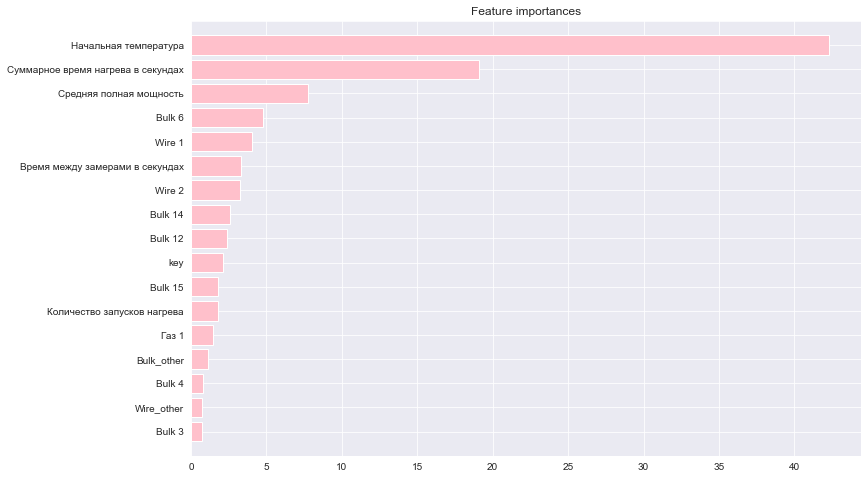

In [70]:
plt.figure()
plt.title("Feature importances")
plt.barh(range(x.shape[1]), importances[indices],
       color="pink", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(x.shape[1]), [feature_names[i] for i in indices])
plt.ylim([-1, x.shape[1]])
plt.show()

Мы помним, что у нас были довольно сильно скоррелированы признаки `Суммарное время нагрева в секундах` и
`Количество запусков нагрева`(0.799038). Мы видим, что для модели более важным признаком является первый из
перечисленных, второй же почти незначим. Избавимся на него и посмотрим на итоговую метрику.

In [71]:
x_train = x_train.drop(columns=['Количество запусков нагрева', 'Wire_other', 'Bulk 3', 'Bulk 4', 'Bulk_other', 'Газ 1', 'Bulk 15'])
x_test = x_test.drop(columns=['Количество запусков нагрева', 'Wire_other', 'Bulk 3', 'Bulk 4', 'Bulk_other', 'Газ 1', 'Bulk 15'])

In [72]:
model = CatBoostRegressor(iterations=5000, depth=3, loss_function='MAE', verbose=100)
model.fit(x_train, y_train, eval_set=(x_test,y_test))
cat_predict=model.predict(x_test)

0:	learn: 7.9582464	test: 8.0192100	best: 8.0192100 (0)	total: 739us	remaining: 3.7s
100:	learn: 5.2835728	test: 5.5799771	best: 5.5799771 (100)	total: 61.9ms	remaining: 3s
200:	learn: 4.6892637	test: 5.0712613	best: 5.0712613 (200)	total: 154ms	remaining: 3.68s
300:	learn: 4.3371391	test: 4.7944917	best: 4.7944917 (300)	total: 234ms	remaining: 3.65s
400:	learn: 4.0934406	test: 4.6253213	best: 4.6247967 (399)	total: 302ms	remaining: 3.47s
500:	learn: 3.9320542	test: 4.5375637	best: 4.5375637 (500)	total: 364ms	remaining: 3.27s
600:	learn: 3.8185514	test: 4.4812729	best: 4.4810759 (598)	total: 426ms	remaining: 3.12s
700:	learn: 3.7308960	test: 4.4387026	best: 4.4387026 (700)	total: 486ms	remaining: 2.98s
800:	learn: 3.6560890	test: 4.4077814	best: 4.4076751 (799)	total: 548ms	remaining: 2.87s
900:	learn: 3.5876123	test: 4.3908434	best: 4.3908434 (900)	total: 619ms	remaining: 2.81s
1000:	learn: 3.5279819	test: 4.3746263	best: 4.3745043 (999)	total: 760ms	remaining: 3.04s
1100:	learn: 3.4

## Вывод


Мы добились требуемого результата сразу на трех моделях. Линейная регрессия показала себя хуже всех, тем не менее
 удалось достигнуть mae ~ 6. Лучшими моделями оказались CatBoost и случайный лес. Выбрали модель CatBoost из-за скорости
 обучения. Построили график важности факторов. Благодаря графику смогли избавиться от мультиколлинеарности путем
 удаления менее значимого скорелированного признака. Также удалили незначимые признаки, благодаря чему получили прирост
 требуемой метрики. Итоговое значение mae ~ 4.18

## Отчет по решению

Представленный план работы был выполнен в полном объеме. В результате проделанной работы нам удалось:

- Изучить полученные данные
    - избавиться от выбросов в данных;
    - построить распределение мощностей;
    - заменить сильнокоррелирующие между собой мощности на полную мощность по формуле;
- Произвести расчет дополнительных значений
    - вычислили суммарное время нагрева электродами;
    - рассчитали количество запусков нагрева электродами;
    - добавили отдельную группу в данные о подаче для редких сыпучих материалов;
    - вычислили первую и последнюю температуры при замерах
        - удалили записи с пропущенными значениями (т.к. конечная температура -- целевой признак);
    - объединили данные о редких проволочных материалов в одну группу;
    - заменили пропущенные значения нулями там, где это было возможно (см. пункт о температуре)
- Получили итоговую таблицу
    - соединили промежуточные таблицы в одну итоговую;
    - удалили записи содержащие NaN значения;
    - перевели время между замерами и суммарное время нагрева электродами в секунды;
    - удалили признаки формата datetime;
    - построили матрицу корреляций;
- Составили план моделирования
- Провели моделирование
    - разделили данные на тренировочную и тестовую выборки
        - убедились в правильности распределения и размерах выборок;
    - обучили модель RandomForestRegressor(mae <5)
        - вывели набор лучших гиперпараметров при рандомсерче;
        - вывели mae полученное на выборках;
    - обучили модель LinearRegression(mae ~6)
        CatBoostRegressor
    - обучили модель CatBoostRegressor(mae <5)
        - вывели mae полученное на выборках;
- Выбрали наилучшую модель (в нашем случае, таких оказалось две, выбрали CatBoostRegressor)
    - построили график важности факторов(feature importance);
    - избавились от мультиколлинеарности путем удаления менее значимого скорелированного признака;
    - так же удалили наименее значимые признаки, для улучшения метрики;
    - повторно вычислили метрику на измененном наборе данных;

Основная задача компании -- уменьшение потребления электроэнергии на этапе обработки стали. К сожалению мы не можем
повлиять на это напрямую. Перед нами стояла задача предсказания конечной температуры сплава.
 Судя по результатам, самые значимые признаки -- первоначальная температура стали,
 суммарное время нагрева в секундах, средняя полная мощность.
